# Prueba 2 - análisis de revisiones positivas y negativas

# Introducción

El objetivo es identificar cuando una reseña es positiva o negativa, para esto se realiza una exploracion de los datos dados, se hace limpieza y tratamiento de los datos con el objetivo de usarlos para generar un modelo que pueda predecir si la reseña es positiva o negativa.

In [1]:
# cargando liberías básicas de procesamiento de DataFrames y de texto
import numpy as np
import pandas as pd
import spacy
import string
import re

from sklearn.model_selection import train_test_split
from spacy.tokens import DocBin

In [2]:
df_rev = pd.read_csv('NLP prueba 2.csv', index_col=0)
df_rev

,text,tag
0,"in exotica everybody is watching , and what is...",pos
1,some of the gags are so carefully innocuous th...,neg
2,press junkets are a haven for control freaks .,neg
3,"then i realized he was , and i was watching it .",neg
4,uh huh .,neg
...,...,...
29405,"roro ( nicknamed "" jalla "" ) is having family ...",neg
29406,"in three days time , or something .",neg
29407,director nicholas hytner is guilty of encourag...,neg
29408,neighbor runs a small failing grocery store .,neg


Como las revisiones se encuentran en inglés, se carga el módulo de la librería de este lenguaje

In [3]:
nlp = spacy.load('en_core_web_sm')

stopwords = spacy.lang.en.stop_words.STOP_WORDS
punctuation = string.punctuation

# Análisis exploratorio

La parte más importante de la clasificación se encuentra en la revisión de la información y la limpieza de los datos. 

En primer lugar se revisa si hay información faltante.

In [4]:
print('Valores faltantes por columnas del DataFrame:')
df_rev.isna().sum()

Valores faltantes por columnas del DataFrame:


text    17
tag      8
dtype: int64

In [5]:
# Revisando las opiniones sin etiqueta
df_rev[df_rev.tag.isna()]

,text,tag
904,"A grandly ambitious, warmhearted, wildly uneve...",NaN
1137,"Stunning visuals and imagery, exceptional dire...",NaN
3936,If only the scares were better.,NaN
3975,Candyman bolsters an already robust mythos wit...,NaN
5011,"In short, a turkey.",NaN
13436,The film's disarming romcom sensibilities are ...,NaN
20433,I found this movie to be very engrossing and e...,NaN
26480,this movie is a complete joke,NaN


La información faltante es pequeña en comparacion al número total de revisiones. 

Del total, hay 17 opiniones faltantes, algunas de las cuales tienen su etiqueta de positiva o negativa. Esta es una característica esencial, con etiqueta pero sin la opinión es inútil tomar esas muestras y no hay forma de completar esta información. Por otro lado sería posible asignar manualmente una etiqueta a partir del contenido, siempre y cuando el número de muestras sin etiquetas pero con texto sea bajo. En big data podría entrenarse el modelo **sin estos datos**, alcanzar un buen desempeño en datos de entrenamiento, y luego etiquetar las muestras faltantes. 

En este caso no se asignan etiquetas ya que es lo que se haría en un modelo de big data.

## Distribucion de las etiquetas

Para el análisis y posterior entrenamiento de modelos es importante evaluar la distribución de las categorías, si una categoría es abrumadoramente mayoritaria este será un elemento relevante para el proceso de análisis y desarrollo del modelo de predicción. Una distribución muy desigual puede llevar a un modelo predictivo a ignorar la categoría minoritaria.

In [6]:
cat_dist = df_rev.tag.value_counts()
print(cat_dist)
print(f'\nDistribución de categorias \n Positivas: {cat_dist[1]/(np.sum(cat_dist)):.3f}, Negativas: {cat_dist[0]/(np.sum(cat_dist)):.3f}')

neg    25434
pos     3968
Name: tag, dtype: int64

Distribución de categorias 
 Positivas: 0.135, Negativas: 0.865


De esta forma es posible obtener información relevante, el 87% de las opiniones registradas fueron etiquetadas como negativas. Para entrenar un modelo debe usarse alguno de los métodos que lidian con imbalances, ya sea a través de métodos como el uso pesos, la reducción de la categoría mayoritaria, o la creación de nuevas muestras minoritarias (aunque en este caso es difícil). Un modelo incapaz de discriminar categorías tendría una exactitud de 87% si etiqueta todas las opiniones como negativas.

## Longitud en palabras

En el análisis de texto, a menudo es útil revisar el número de palabras de cada opinión, a continuacion se muestra la distribución del número de palabras en los datos provistos.

In [7]:
# se crea una columna nueva con el número de palabras del texto, separadas por espacio
df_rev['words'] = df_rev.text.apply(lambda x : len( str(x).split() ) )

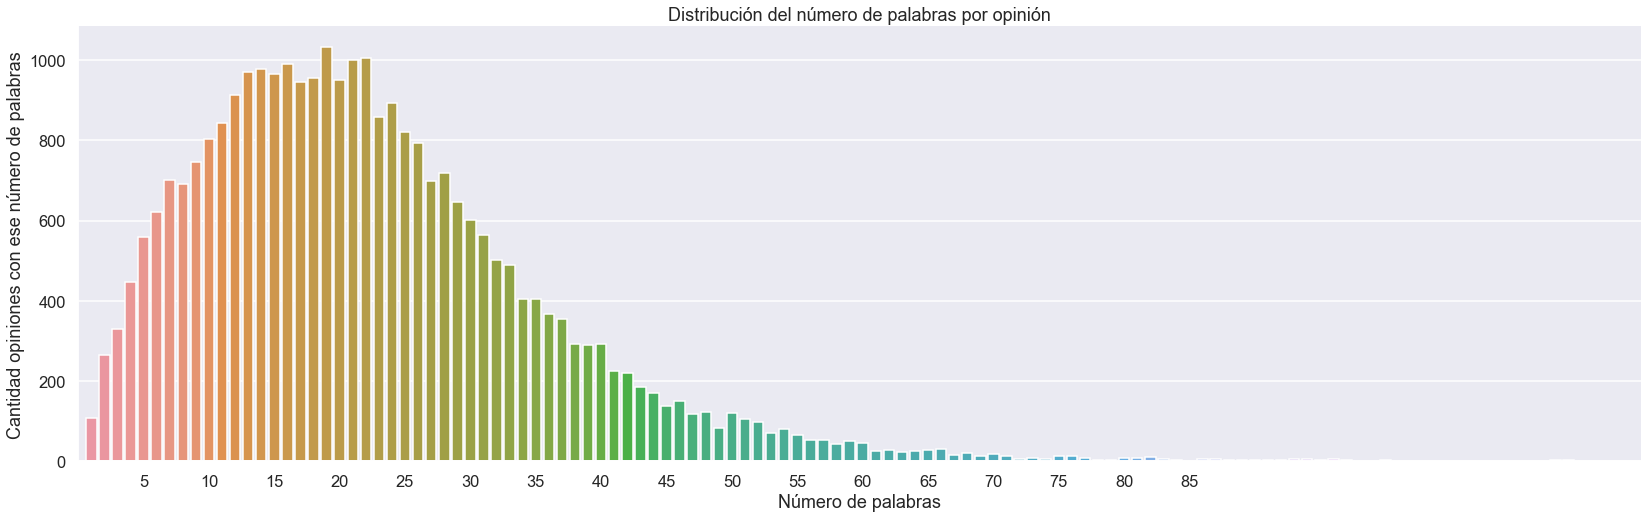

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df_wc = df_rev.groupby('words').size()

sns.set_context('talk')
sns.set_style('darkgrid')

plt.figure(figsize=(28,8))
plt.title("Distribución del número de palabras por opinión")
sns.barplot(x=df_wc.index, y=df_wc.values)
plt.xticks([i-1 for i in range(0,90) if i%5==0])
plt.xlabel("Número de palabras")
plt.ylabel("Cantidad opiniones con ese número de palabras")
sns.despine()
plt.show()

In [9]:
# una descripcion estadística del número de palabras encontrado
df_rev.words.describe()

count    29410.000000
mean        22.403094
std         13.516609
min          1.000000
25%         13.000000
50%         20.000000
75%         29.000000
max        179.000000
Name: words, dtype: float64

In [10]:
# revisando las opiniones con menos palabras
df_rev[(df_rev.words<=3)].text

4              uh huh .
25                why ?
35               ummm !
105               fun ?
116      or substance .
              ...      
29203     challenging ?
29304        honestly .
29318         if only .
29322      piano duel ?
29348       and gordy !
Name: text, Length: 702, dtype: object

Las **opiniones más cortas carecen de sentido**, por lo que puede mejorar el desempeño del algoritmo si estas se eliminan.

In [11]:
# revisando las opiniones con más palabras
df_rev[(df_rev.words>150)].text

6785     the film gives us charlton heston ( in one of ...
23995    since that plot is incredibly lame and a track...
27929    after the setup , in which the robinson family...
Name: text, dtype: object

In [12]:
# tomando un ejemplo
df_rev[(df_rev.words>150)].text.iloc[2]

'after the setup , in which the robinson family--father john ( william hurt , looking and sounding as spaced out as he does in interviews ) , mother maureen ( rogers , wasted ) , daughters judy ( heather graham , ditto ) and penny ( a heavily made-up chabert , looking like a junior version of neve campbell in wild things ) , and son will ( young newcomer johnson , making the best of it ) --and pilot don west ( leblanc , doing a bad han solo impression ) find themselves lost in space after their ship is sabotaged by evil stowaway dr . smith ( a watered-down but still-lively oldman , cashing a paycheck and loving every minute ) , the script\'s " stream " of events becomes so fragmented and random that it seems to be made up as it goes along--and hopkins does little to make what does go on the slightest bit interesting .'

Al mirar las **opiniones más largas**, son pocas y parecen ser válidas, por lo que no sería recomendable removerlas.

In [13]:
def common_words(df, user_list=[]):
    from collections import Counter
    word_count = Counter()
    for review in df.text:
        if isinstance(review,float): continue
        texto = review.split()   # se podria hacer tokenizando
        for word in texto:
            if word in [*stopwords, *punctuation, *user_list]: continue
            word_count[word] += 1
    return word_count

In [14]:
# revisando las palabras más comunes en las revisiones positivas
cw = common_words(df_rev[df_rev.tag=="pos"])
cw.most_common(15)

[('film', 612),
 ('movie', 309),
 ("it's", 223),
 ('like', 199),
 ('story', 150),
 ('good', 146),
 ('life', 135),
 ('time', 133),
 ('character', 118),
 ('way', 113),
 ('films', 111),
 ('characters', 106),
 ('best', 98),
 ('people', 93),
 ('new', 93)]

In [15]:
# revisando las palabras más comunes en las revisiones negativas, no se intersectan con las de las revisiones positivas
common_pos = [tupl[0] for tupl in cw.most_common(25)]

cw = common_words(df_rev[df_rev.tag=="neg"], common_pos)
cw.most_common(15)

[('bad', 835),
 ('plot', 684),
 ("don't", 540),
 ('know', 508),
 ('action', 488),
 ("there's", 464),
 ('movies', 442),
 ('better', 440),
 ('big', 436),
 ('end', 418),
 ('work', 402),
 ("isn't", 389),
 ('script', 384),
 ('think', 371),
 ('going', 369)]

# Limpieza de datos

## Pipeline

A continuación se definen las funciones de preprocesamiento y de generación de los archivos que necesita spacy

In [16]:
def remove_url(txt):
    txt = re.sub(r"https?:\S*", "", txt, flags=re.MULTILINE)
    return txt

def clean_tokenizer(txt):
    """
    Given a string, tokenizes the string, with lower case, no stopwords and no punctuation
    
    Input:
     - string
     
    Output:
     - list of tokenized words
    """
    txt = remove_url(txt)
    txt = nlp(txt)
    
    # lematizacion y remocion de stopwords
    tokens = [word.lemma_.lower().strip() for word in txt if word.text not in [*stopwords,*punctuation]]
    
    return tokens


def clean_text(txt):
    return " ".join(clean_tokenizer(txt))


def make_docs(df):
    """
    Transforms data into spacy documents
    
    Input:
     - data: is a dataframe with 'text' and 'tag' columns
     
    Output:
     - docs: a list of spacy tokens.doc.Doc, which are objects with the attributes needed by spacy
     - data_train: preprocessed DataFrame
     
    """
    docs = []
    
    # turning data into tuples
    data = tuple( zip( df.text.tolist(), df.tag.to_list() ) )
    
    # appending the object spacy.token.doc.Doc into a list
    for doc, label in nlp.pipe(data, as_tuples=True):
        doc.cats['positive'] = label
        doc.cats['negative'] = 1 ^ label  # negacion XOR
        docs.append(doc)
        
    return docs, data

## Preprocesamiento: Transformaciones para entrenamiento

In [17]:
print(df_rev) # original

# eliminando valores faltantes y duplicados
df_rev = df_rev.dropna()
df_rev = df_rev.drop_duplicates()

# lowercase, lemizacion, limpiando stopwords y puntuacion
df_rev.text = df_rev.text.apply(clean_text)
df_rev['words'] = df_rev.text.apply(lambda x : len( str(x).split() ) )

# eliminando muestas con bajo numero de palabras
df_rev = df_rev[(df_rev.words>3)]

# codificacion one hot para entrenar los modelos
tag_onehot = {'pos':1, 'neg':0}
df_rev.tag = df_rev.loc[:,'tag'].replace(tag_onehot)

print(df_rev) # luego de las transformaciones

                                                    text  tag  words
0      in exotica everybody is watching , and what is...  pos     14
1      some of the gags are so carefully innocuous th...  neg     11
2         press junkets are a haven for control freaks .  neg      9
3       then i realized he was , and i was watching it .  neg     12
4                                               uh huh .  neg      3
...                                                  ...  ...    ...
29405  roro ( nicknamed " jalla " ) is having family ...  neg     12
29406                in three days time , or something .  neg      8
29407  director nicholas hytner is guilty of encourag...  neg     31
29408      neighbor runs a small failing grocery store .  neg      8
29409  what i admire most about city of angels is its...  pos     13

[29410 rows x 3 columns]
                                                    text  tag  words
0             exotica everybody watch bad everybody know    1      6
1       

In [18]:
#creando un dataset balanceado
df_list = []
for i in range(2):
    df = df_rev[df_rev.tag==i].sample(3000)
    df_list.append(df)
df_balanced = pd.concat(df_list)
print(df_balanced.tag.value_counts())

# separando entre sets de entrenamiento y test
Xtrain, Xtest, ytrain, ytest = train_test_split(df_balanced.text, df_balanced.tag, stratify=df_balanced.tag, test_size=0.2) # para los otros modelos

# separando dataset en entrenamiento y test
df_train, df_test = train_test_split(df_balanced, stratify=df_balanced.tag, test_size=0.2) # para spacy

0    3000
1    3000
Name: tag, dtype: int64


In [19]:
# pasando los DataFrames a través del preprocesamiento y obteniendo los objetos de spacy
train_docs, train_data = make_docs(df_train)
test_docs, test_data = make_docs(df_test)

In [20]:
# creando los archivos de spacy en disco
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("./spacy_data/text_train.spacy")

doc_bin = DocBin(docs=test_docs)
doc_bin.to_disk("./spacy_data/text_test.spacy")

In [21]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [22]:
!python -m spacy init fill-config ./spacy_data/base_config.cfg ./spacy_data/config.cfg

[+] Auto-filled config with all values
[+] Saved config
spacy_data\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [23]:
!python -m spacy train ./spacy_data/config.cfg --output ./spacy_data/output --paths.train ./spacy_data/text_train.spacy --paths.dev ./spacy_data/text_test.spacy

^C


# Resultado del entrenamiento de spacy

A continuacion se definen funciones para evaluar el desempeño de modelos de aprendizaje de máquina

In [24]:
import sklearn

sns.set_style('white')


def plot_cm(y_test, predictions, normalize=None, **kargs):
    from sklearn.metrics import ConfusionMatrixDisplay

    cm = sklearn.metrics.confusion_matrix(y_test, predictions, normalize=normalize)
    cm_fig = ConfusionMatrixDisplay(cm, display_labels=np.arange(2))
    cm_fig.plot(cmap='Blues', **kargs)
    return cm


def plot_roc(name, y_true, predictions, **kwargs):
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, predictions)
    auc_val = sklearn.metrics.auc(fpr, tpr)
    roc_display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_val, estimator_name=name)
    roc_display.plot(**kwargs)
    return auc_val


def plot_rpc(name, y_true, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_true, predictions)
    prc_display = sklearn.metrics.PrecisionRecallDisplay(
        precision=precision, recall=recall, average_precision=np.mean(precision),
        estimator_name=name)
    prc_display.plot(linewidth=2, **kwargs)


def eval_clf(y_test, y_pred, avoid_prob=1, clf=None):
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    b_acc = sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred)
    recall = sklearn.metrics.recall_score(y_test, y_pred)

    print(f'Accuracy \t{acc:.3f} \t Balanced acc: \t{b_acc:.3f}')
    print(f'Recall: \t{recall:.3f} \t Precision: \t{precision:.3f}\n')

    # confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    cm = plot_cm(y_test, y_pred, ax=ax[0], values_format='')
    cm_n = plot_cm(y_test, y_pred, normalize='true', ax=ax[1], values_format='.3f')

    # plotting curves
    auc = np.nan
    if not avoid_prob:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        auc = plot_roc("roc", y_test, y_pred_proba, ax=ax[0])
        plot_rpc("rpc", y_test, y_pred_proba, ax=ax[1])
        ax[0].grid(True); ax[1].grid(True)
    plt.show()
    return b_acc, recall, precision, auc

In [25]:
# cargando el mejor modelo entrenado
nlp = spacy.load('./spacy_data/output/model-best')

text = input("Please input a review: ")
doc = nlp(text)
if doc.cats['positive']>0.5:
    print("Positive review")
else:
    print("Negative review")

Please input a review:  this is a bad movie


Negative review


Accuracy 	0.561 	 Balanced acc: 	0.561
Recall: 	0.600 	 Precision: 	0.556



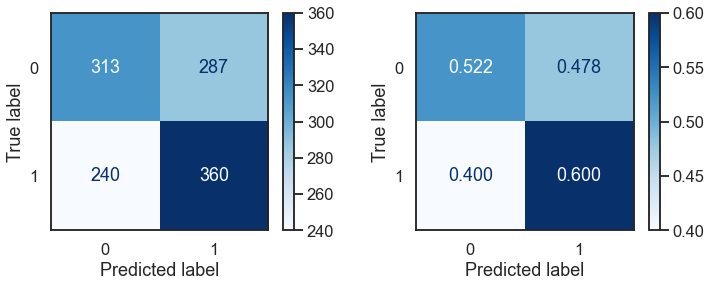

(0.5608333333333333, 0.6, 0.5564142194744977, nan)

In [38]:
nlp = spacy.load('./spacy_data/output/model-best')

def spacy_predict(text):
    doc = nlp(text)
    if doc.cats['positive']>=0.5: return 1
    return 0

ypred = np.asarray(df_test.text.apply(spacy_predict))
eval_clf(df_test.tag.values, ypred)

Spacy es una buena libería para procesamiento de textos, pero aún así el costo computacional es alto y se favorece mucho por el suo de GPU. Además el manejo de la libería con datasets imbalanceados se hace un poco limitado. 

# Usando otros modelos
Es posible usar spacy para el preprocesamiento y otras liberías para el entrenamiento de modelos, lo que puede favorecer el trabajo con otros ingenieros y el uso de herramientas adicionales.

## Deep learning

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
# usando el tokenizer de keras para vectorizar el texto
tokenizer = Tokenizer(num_words=20000)

#ajustando el tokenizer a las palabras del texto
tokenizer.fit_on_texts(Xtrain)

# transformando en vector
Xtrain_seq = tokenizer.texts_to_sequences(Xtrain)
Xtest_seq = tokenizer.texts_to_sequences(Xtest)

# aplicando padding para uniformar los vectores
train_seq = pad_sequences(Xtrain_seq, maxlen=110)
test_seq = pad_sequences(Xtest_seq, maxlen=110)

In [30]:
# definiendo un modelo de ANN
model = Sequential()
model.add(Embedding(20000, 128, input_length=110))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 110, 128)          2560000   
_________________________________________________________________
dense (Dense)                (None, 110, 128)          16512     
_________________________________________________________________
dropout (Dropout)            (None, 110, 128)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 110, 128)          16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 2,593,669
Trainable params: 2,593,669
Non-trainable params: 0
______________________________________________

In [31]:
model.fit(train_seq, ytrain, validation_split=0.2, epochs=10)

Epoch 1/10
120/120 [==============================] - 5s 38ms/step - loss: 0.7901 - accuracy: 0.5042 - val_loss: 0.6997 - val_accuracy: 0.5094
Epoch 2/10
120/120 [==============================] - 4s 32ms/step - loss: 0.6801 - accuracy: 0.5729 - val_loss: 0.6851 - val_accuracy: 0.5625
Epoch 3/10
120/120 [==============================] - 4s 34ms/step - loss: 0.5590 - accuracy: 0.7326 - val_loss: 0.7431 - val_accuracy: 0.5719
Epoch 4/10
120/120 [==============================] - 4s 36ms/step - loss: 0.3644 - accuracy: 0.8448 - val_loss: 0.8743 - val_accuracy: 0.5823
Epoch 5/10
120/120 [==============================] - 4s 36ms/step - loss: 0.2397 - accuracy: 0.9070 - val_loss: 1.0914 - val_accuracy: 0.5740
Epoch 6/10
120/120 [==============================] - 4s 33ms/step - loss: 0.1588 - accuracy: 0.9375 - val_loss: 1.3371 - val_accuracy: 0.5615
Epoch 7/10
120/120 [==============================] - 4s 34ms/step - loss: 0.1069 - accuracy: 0.9596 - val_loss: 1.5888 - val_accuracy: 0.5708

In [33]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=110))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu',
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l1(1e-4),
                activity_regularizer=regularizers.l1(1e-5)))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 110, 128)          2560000   
_________________________________________________________________
dense_3 (Dense)              (None, 110, 128)          16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 128)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 110, 128)          16512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 2,593,669
Trainable params: 2,593,669
Non-trainable params: 0
____________________________________________

In [34]:
model.fit(train_seq, ytrain, validation_split=0.2, epochs=50)

Epoch 1/50
120/120 [==============================] - 6s 41ms/step - loss: 0.8760 - accuracy: 0.4831 - val_loss: 0.7596 - val_accuracy: 0.5094
Epoch 2/50
120/120 [==============================] - 5s 39ms/step - loss: 0.7254 - accuracy: 0.5654 - val_loss: 0.7442 - val_accuracy: 0.5333
Epoch 3/50
120/120 [==============================] - 5s 39ms/step - loss: 0.6110 - accuracy: 0.7208 - val_loss: 0.8058 - val_accuracy: 0.5562
Epoch 4/50
120/120 [==============================] - 4s 35ms/step - loss: 0.4356 - accuracy: 0.8284 - val_loss: 0.9456 - val_accuracy: 0.5823
Epoch 5/50
120/120 [==============================] - 4s 35ms/step - loss: 0.2905 - accuracy: 0.8891 - val_loss: 1.0759 - val_accuracy: 0.5927
Epoch 6/50
120/120 [==============================] - 4s 35ms/step - loss: 0.1965 - accuracy: 0.9323 - val_loss: 1.3295 - val_accuracy: 0.6010
Epoch 7/50
120/120 [==============================] - 5s 43ms/step - loss: 0.1465 - accuracy: 0.9516 - val_loss: 1.5141 - val_accuracy: 0.5917

Accuracy 	0.576 	 Balanced acc: 	0.576
Recall: 	0.552 	 Precision: 	0.580



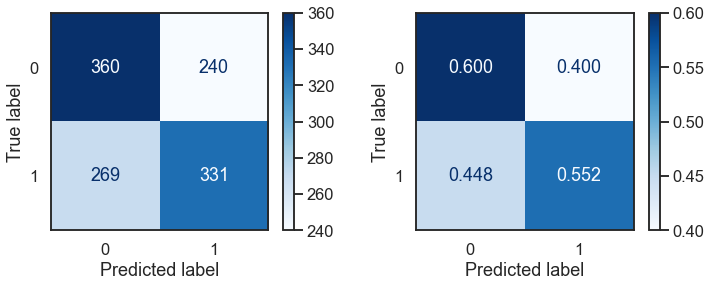

(0.5758333333333333, 0.5516666666666666, 0.5796847635726795, nan)

In [36]:
ypred = np.argmax(model.predict(test_seq),axis=-1)

eval_clf(ytest, ypred)

El modelo de ANN logra un desempeño por encima del azar, aunque no es el valor esperado. Para su comparación se procede a realizar un modelo más simple, la regresión logística.

## Regresión logística

La regresión logística es un modelo estadístico sencillo que permite obtener la probabilidad de que una muestra pertenezca a una categoría. El modelo original se implementa para categorías binarias lo que funciona perfecto en este caso

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}


from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

bow_vector = CountVectorizer( tokenizer = clean_tokenizer, ngram_range=(1,1) )
tfidf_vector = TfidfVectorizer( tokenizer = clean_tokenizer )

pipe = Pipeline([( "cleaner", predictors() ),
                 ( "vecorizer", bow_vector), 
                 ( "classifier", classifier )])

In [40]:
pipe.fit(Xtrain, ytrain)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x000001FE50903280>),
                ('vecorizer',
                 CountVectorizer(tokenizer=<function clean_tokenizer at 0x000001FE4EC4D1F0>)),
                ('classifier', LogisticRegression())])

In [ ]:
# evaluacion del modelo
ypred = pipe.predict(Xtest)

eval_clf(ytest, ypred)

In [41]:
def search_clf(clf, param_grid, X_train, y_train, cv=6, scoring=None,
               rand_search=1, searches=10):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import RepeatedStratifiedKFold

    if cv=='RKfold': cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=1)
    if scoring is None: scoring = "balanced_accuracy"

    # random search
    if rand_search == 1:
        search = RandomizedSearchCV(
            estimator=clf, 
            param_distributions=param_grid, 
            n_iter=searches, 
            scoring=scoring, 
            cv=cv, 
            verbose=1, n_jobs=-1, random_state=1,
            )
    
    # grid search
    else:
        search = GridSearchCV(
            estimator=clf, 
            param_grid=param_grid, 
            scoring=scoring, 
            cv=cv, 
            verbose=1, n_jobs=-1,
            )
        
    # training
    result = search.fit(X_train, y_train)
    print(f'Best Hyperparameters: {result.best_params_}, Best score: {result.best_score_:.3f}')

    return result 

In [ ]:
# haciendo ajustamiento aleatorio de hiperparametros para mejorar el desempeño del clasificador
from scipy.stats import loguniform

param_grid_lr = {
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
    'C' : loguniform(1e-5, 100),
}


clf = search_clf(
    classifier, param_grid_lr, train_seq, ytrain, cv=5, scoring='accuracy', rand_search=1, searches=50,
    )  #'RKfold'

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
ypred = clf.predict(test_seq)
eval_clf(ytest, ypred)

El modelo logistico no logró buen desempeño en ninguna de las dos formas de entrenamiento.

# Conclusion

Se entrenaron diversos modelos, el mejor modelo, ANN a través de Tensorflow y Keras, logró una precisión del 57.2 % en un dataset balanceado superando el desempeño de Spacy, aunque no se consigue un desempeño alto, este se encuentra por encima del azar. El peor desempeño ocurrió con el modelo de regresión logística, el modelo más simple, que era lo esperado.

Se puede realizar una variedad de ajustes a los modelos, pero debido al tiempo limitado estos se exploran de forma muy superficial. El análisis de este tipo de información se puede enriquecer con una exploración más detallada, que permita evaluar las posibles falencias de los modelos. 